**A2C** (Advantage Actor Critic), is a Policy Gradient method, that uses a neural network to model the policy (actor) and another neural network to model the value function (critic). Actor-critic arquitectures are very popular in DRL.

The actor network works as the policy in VPG, which means that **the state and the actions can be continuous and/or discrete**.

The critic is a neural network that takes as input the current state $s_t$, and returns the expected value for that state, $V(s_t)$.

It is possible to see A2C as VPG with a more complex estimator of the reward: instead of using the return of a trajectory, we use the value of the critic in order to stabilize learning. Thus, it is no surprise that there are many similitudes between VPG and A2C.

The algorithm works in two main phases:
* First, it builds a batch of data composed of states, actions, rewards and next states, by interacting with the environment. As in VPG, we directly use the policy to sample.
* Then, the actor and the critic networks are updated. In order to update both of them, it is key to compute the Advantage:
$$
A^{\pi}(s_{t,}a_{t})=Q^{\pi}(s_{t},a_{t})-V^{\pi}(s_{t})\approx r_{t}+\gamma V^{\pi}(s_{t+1})-V^{\pi}(s_{t})
$$
    * To update the critic, note that the Advantage is an estimator of the TD error, so we just minimize the squared Advantage (MSE criterion).
    * To update the actor, we use the same policy gradient update used in VPG, but using the advantage to multiply the log-probabilities of the policy:
$$
\nabla_{\phi}J(\pi_{\phi})=\mathbb{E}_{\tau\sim\pi_{\phi}}\Bigg[\sum_{t=0}^{T}\nabla_{\phi}\log\pi_{\phi}(a_{t}|s_{t})\cdot A^{\pi}(s_{t,}a_{t})\Bigg]
$$

Finally, it is important to note that the critic guides the actor, so it is essential that the critic learns faster, in order to guide the actor well. This can be done by updating the critic more often, using different learning rates, or even both ideas.

Let's start with the code! First, as usual, we import the main libraries we are going to use for this simple version of A2C, applied to the Cartpole problem. We need to install the Gymnasium library, which implements the Cartpole.

In [19]:
!pip install gymnasium
import torch
import torch.nn as nn
import numpy as np
import random
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline

Next, we are going to create a simple MLP model to create both the actor and the critic. Note that the neural network is quite simple: depending on the problem to be addressed, it may suffice to use simple neural networks in DRL (and hence, it is possible to train using a CPU).

As in VPG, the actor will use a Softmax activation (related to a Categorical distribution policy). As in DQN, the critic will have no activation, as the value function may take values in $\mathbb{R}$.

In [20]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, final_activation=None, hidden_size=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)
        self.relu = nn.ReLU()
        self.final_activation = final_activation

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x


Next, we are going to define the agent. The methods implemented are:
* The **init** method sets up all parameters and initializes the actor and the critic. Note that we set the actor learning rate lower than the critic learning rate, to facilitate convergence (i.e., the critic should learn faster).
* The **get_action** method samples one action from the policy. As the code assumes a Categorical distribution, we sample using such a distribution.
* The **train** method is the main method: it takes as input an environment, and proceeds to train the algorithm using the two phases mentioned before: it interacts with the environment to build a batch of data, and then updates the actor and the critic. As mentioned in class, note that the *loss* is not an actual loss, as it is the gradient of the objective $J$ (although it is standard to call it loss).

In [21]:
class A2CAgent:  # A2C Agent
    def __init__(self, state_size, action_size, device=None):
        # Define state and action space sizes
        self.state_size = state_size
        self.action_size = action_size  # In this implementation, we use discrete actions
        # create the policy model and target model
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # To use GPU if available
        else:
            self.device = device
        print('A2C is using device: ', self.device)
        self.actor = MLP(self.state_size, self.action_size, hidden_size=64, final_activation=nn.Softmax(dim=1)).to(self.device)
        self.critic = MLP(self.state_size, 1, hidden_size=64).to(self.device)
        # Define the optimizer
        self.learning_rate_actor = 0.005  # Learning rate for ADAM optimizer
        self.learning_rate_critic = 0.01  # Learning rate for ADAM optimizer
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.learning_rate_actor)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.learning_rate_critic)

    # Epsilon greedy policy
    def get_action(self, state):
        state = np.reshape(state, [1, self.state_size])
        ac_prob = self.actor(torch.from_numpy(state).to(self.device)).detach().cpu().numpy()
        return np.random.choice(self.action_size, p=ac_prob[0])

    # Function to train the agent
    def train(self, env, max_episodes=300, verbose=True, verbose_interval=10, batch_size=64, gamma=0.99):

        scores, episodes, losses = [], [], []  # To store values for plotting
        break_flag = False  # To stop training when the agent has successfully learned

        for e in range(max_episodes):
            self.actor.eval()  # Set the actor to evaluation mode
            self.critic.eval()  # Set the critic to evaluation mode

            states, next_states, actions, rews, episode_returns = [], [], [], [], []  # To store the samples of the batch
            state, _ = env.reset(seed=np.random.randint(1000))  # Set the initial state
            rews_eps = []  # Use this to track the rewards obtained in the episode (rews has values from several episodes)

            while True:
                states.append(state.copy())  # Save the state
                action = self.get_action(state)  # Get the action
                state, reward, terminated, truncated, info = env.step(action)  # Go one step in the environment
                done = terminated or truncated
                # Save info for the batch
                actions.append(action)
                rews.append(reward)
                rews_eps.append(reward)
                next_states.append(state)

                if done:  # If the episode has finished
                    episode_returns.append(np.sum(rews_eps))  # Save the episode return

                    #reset variables
                    state, _ = env.reset(seed=np.random.randint(1000))  # Set the initial state
                    rews_eps = []
                    if len(states) >= batch_size:
                        break  # If we have enough samples, stop the episode. Note that batch_size is the minimum number of samples

            states = torch.from_numpy(np.vstack(states)).to(self.device)
            actions = torch.from_numpy(np.vstack(actions)).type(torch.LongTensor).to(self.device)
            rews = torch.from_numpy(np.vstack(rews)).to(self.device)
            next_states = torch.from_numpy(np.vstack(next_states)).to(self.device)

            # Now, train the critic and the actor
            self.actor.train()
            self.actor_optimizer.zero_grad()  # Reset the optimizer
            self.critic.train()  # Set the critic to training mode
            self.critic_optimizer.zero_grad()  # Reset the optimizer

            advantage = rews + gamma * self.critic(next_states) - self.critic(states)  # Compute the advantage
            critic_loss = advantage.pow(2).mean()  # MSE loss

            probs = self.actor(states)  # Get the action probabilities
            log_probs = torch.log(probs)  # Get the log probabilities of the actions taken
            log_probs_actions = torch.gather(log_probs, 1, actions)  # Get the log probabilities of the actions taken
            actor_loss = -(log_probs_actions * advantage).mean()  # Policy gradient loss

            loss = actor_loss + critic_loss  # Total loss
            loss.backward()  # Backpropagate the loss
            self.critic_optimizer.step()  # Update the parameters of the critic
            self.actor_optimizer.step()  # Update the parameters of the actor

            # Save values for plotting
            if verbose and e % verbose_interval == 0:
                print("Episode: {}/{}, score: {}, actor loss: {}, critic loss: {}".format(e, max_episodes, np.mean(episode_returns), actor_loss.item(), critic_loss.item()))

            scores.append(np.mean(episode_returns))
            episodes.append(e)
            losses.append((actor_loss.item(), critic_loss.item()))

            # Stop if mean scores of last 5 episodes is higher than 490
            if np.mean(scores[-min(5, len(scores)):]) > 490:
                break_flag = True
                break
        # Output whether the agent learnt or not
        if break_flag:
            print("Training finished successfully")
        else:
            print("Training finished unsuccessfully")

        return episodes, scores, losses

Let us now describe the environment where we are going to train our agent: the Cartpole problem. We have a moving cart with a pole and a mass on top, and want to keep the pole vertical.

* The state set is continuous and has 4 components: pole angle and angular speed, and cart position and velocity.

* The action set is $A=\left[LF,RF\right]$ and are the forces applied to the cart pole, where $LF$ is a left force and $RF$ is a right force.

* The rewards are $+1$ for every time step that the pole has not fallen: if the pole surpasses a certain angle (i.e., it falls), the episode terminates.

We use the Gymnasium library, which contains many environments implemented for DRL.

The CartPole environment allows up to 500 time steps. That is the maximum time of play. This time could be increased with env._max_episode_steps, but we use 500 for demonstration purposes.

In [22]:
env = gym.make('CartPole-v1')

A known problem of DRL are the reproducibility issues (see Henderson, P., Islam, R., Bachman, P., Pineau, J., Precup, D., & Meger, D. (2018, April). Deep reinforcement learning that matters. In Proceedings of the AAAI conference on artificial intelligence (Vol. 32, No. 1), https://doi.org/10.48550/arXiv.1709.06560).

To prevent that, the code is seeded: note that changing the seed will change the results, as DRL is known to be extremely sensitive to the initial conditions.

In [23]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

We are finally ready! Now, we can train our agent and see what they learn. In order to show the differences between seeds, we are going to run $3$ different initial seeds: note how they have very different convergence properties, in spite of the fact that all hyperparameters are the same, except for the seed!

Again, remember that the loss is not an actual loss! Thus, we must check the convergence using the score.

In [24]:
trials = 3
episodes, scores, losses = [], [], []

for i in range(trials):
    print("Trial {}/{}".format(i + 1, trials))
    # Create the agent
    agent = A2CAgent(env.observation_space.shape[0], env.action_space.n, device='cpu')
    # Train the agent
    e, s, l = agent.train(env, max_episodes=500, verbose=True, verbose_interval=10, batch_size=64)
    episodes.append(e)
    scores.append(s)
    losses.append(l)

Trial 1/3
A2C is using device:  cpu
Episode: 0/500, score: 29.333333333333332, actor loss: 0.6922877461513092, critic loss: 0.9998376638803946
Episode: 10/500, score: 28.0, actor loss: 0.6368996088999902, critic loss: 0.9769849032352073
Episode: 20/500, score: 121.0, actor loss: 0.5214293469870523, critic loss: 0.9580783493368314
Episode: 30/500, score: 57.0, actor loss: 0.37945937149948217, critic loss: 0.7560897130149402
Episode: 40/500, score: 73.0, actor loss: 0.13452738021238386, critic loss: 0.3819072667249875
Episode: 50/500, score: 107.5, actor loss: -0.018356161803278127, critic loss: 0.1352730175445728
Episode: 60/500, score: 91.0, actor loss: -0.0694954418805751, critic loss: 0.39341309591219503
Episode: 70/500, score: 123.0, actor loss: -0.03285216990672168, critic loss: 0.04145656569389536
Episode: 80/500, score: 183.0, actor loss: -0.016081272198673134, critic loss: 0.04136495926268551
Episode: 90/500, score: 181.0, actor loss: -0.04229048538762037, critic loss: 0.0461196

Now, we plot the results: note that some seeds learn, and others do not, just because of the seed. Thus, it is good practice in DRL to run an algorithm several times, over 8-10 seeds, and then average the results of the best 3-5 seeds.

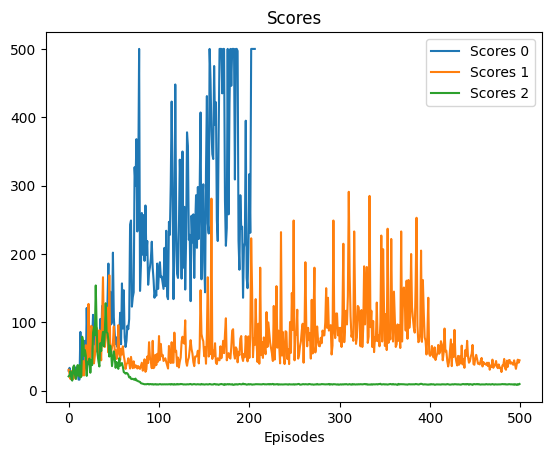

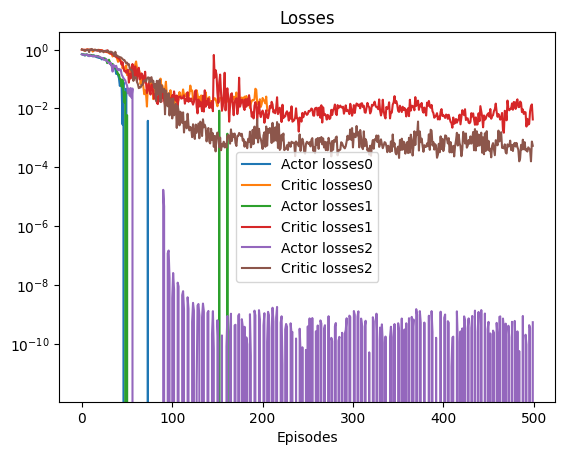

In [30]:
# Plot the scores and losses vs the episodes
fig, ax1 = plt.subplots()

for i in range(trials):
    ax1.plot(episodes[i], scores[i], label='Scores ' + str(i))

ax1.set_xlabel('Episodes')
plt.legend(loc='best')
plt.title('Scores')
plt.show()

# Plot the losses
fig, ax1 = plt.subplots()

for i in range(trials):
    ax1.semilogy(episodes[i], [l[0] for l in losses[i]], label='Actor losses' + str(i))
    ax1.semilogy(episodes[i], [l[1] for l in losses[i]], label='Critic losses' + str(i))

ax1.set_xlabel('Episodes')
plt.legend(loc='best')
plt.title('Losses')
plt.show()

Finally, we will visualize the learned policy.

Obtaining data from trained network
Data obtained
Creating animation


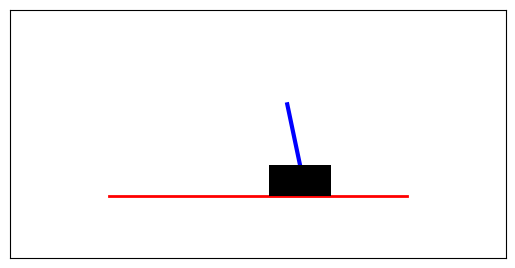

In [26]:
# Run the game once with the trained network and store the values of the position and angle of the cartpole
print("Obtaining data from trained network")
pos_vector=[]
angle_vector=[]
state, _ = env.reset()
state = np.reshape(state, [1, agent.state_size])
done=False
while not done:
    pos_vector.append(state[0,0])
    angle_vector.append(state[0,2])
    action = agent.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = np.reshape(next_state, [1, agent.state_size])
    state = next_state
    if done:
        break
T=len(pos_vector)
print("Data obtained")

# Animate the data: to observe what our network has learned
from matplotlib import animation, patches
from IPython.display import HTML
print("Creating animation")
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-1, 3), aspect=1)
ax.set_xticks([])
ax.set_yticks([])

mag1 = plt.Rectangle((0,0), width= 1, height= 0.5, angle=0, fc='black', alpha=0)
line1, = ax.plot([], [], 'b', zorder=1,linewidth=3.0)
line2, = ax.plot([], [], 'r', zorder=1,linewidth=2.0)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ax.add_patch(mag1)
    return mag1, line1, line2,

def animate(i):
    mag1.set_alpha(1)
    mag1.xy = (pos_vector[i],0)
    x0=pos_vector[i]+0.5
    y0=0.5
    x1=x0+np.cos(np.pi/2-angle_vector[i])
    y1=y0+np.sin(np.pi/2-angle_vector[i])
    line1.set_data([x0, x1], [y0, y1])
    line2.set_data([-2.4, 2.4], [0,0])
    return mag1, line1, line2,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=T,
                               interval=25, blit=True)

HTML(anim.to_jshtml())